AR non-anomaly composites of different variables using different cEOF tests (e.g. DJF, MAM, DJF-MAM). 

Creates significant differences plots for IVT and upper level plots. (e.g. El Nino vs Neutral conditions for each AR type)


## Imports

In [43]:
# Standard Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
import metpy.calc as mpcalc
from metpy.units import units
from IPython.display import Image, display

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from plotter import draw_basemap, add_subregion_boxes, make_cmap
import nclcmaps as nclc
from timeseries import persistence, select_months, create_list_all_dates
from teleconnections import build_teleconnection_df
from statistical_tests import xr_ttest_ind_from_stats

In [44]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [45]:
# Set a default font for all matplotlib text 
rcParams['font.family'] = 'sans-serif'   # font family = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # default sans-serif font = 'Arial'


## Data

In [46]:
# choose season
ssn = 'djfmam'
ceofid = 'HUV500'
neofs = 2 # choose number of eofs
nk = 3 # choose number of clusters

out_path = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
fig_path = path_to_figs + ceofid + '/' + ssn + '/'+ 'neof' + str(neofs) + '/k' + str(nk) + '/'

In [48]:
# import configuration file for dictionary choice
yaml_doc = '../data/config.yml'

config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
#select dictionaries - choose var, anom/nanom, and season
# upper_ precip_ ivt_ and non_anom anom
plot_dict_upper = config['upper_diff']
plot_dict_ivt = config['ivt_diff']
plot_dict_prec = config['precip_diff']

plot_dicts = [plot_dict_upper, plot_dict_ivt, plot_dict_prec]

# djf_dict mam_dict djfmam_dict
ar_dict = config[ssn]
ar_dict['start_date']

'1979-12-01 9:00'

### AR days

In [6]:
def ar_daily_df(ssn, nk):
    out_path = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
    filepath = out_path + 'AR-types_ALLDAYS.csv'
    df = pd.read_csv(filepath)

    # set up datetime index
    df = df.rename(columns={'Unnamed: 0': 'date'})
    df = df.set_index(pd.to_datetime(df.date))
    
    ## Break up columns into different AR Types
    keys = []
    for k in range(nk):
        keys.append("AR_CAT{:1d}".format(k+1,))

    values = np.zeros((len(df.index)))
    dicts = dict(zip(keys, values))

    df_cat = pd.DataFrame(dicts, index=df.index)

    for k in range(nk):
        idx = (df['AR_CAT'] == k+1)
        col = "AR_CAT{:1d}".format(k+1,)
        df_cat.loc[idx, col] = 1
        
    # get total of all AR types
    df_cat['AR_ALL'] = df_cat['AR_CAT1'] + df_cat['AR_CAT2'] + df_cat['AR_CAT3']
    df_cat['AR_CAT'] = df['AR_CAT']
    
    return df_cat

def mjo_index(ref, start_date, end_date):
    '''create a pandas df of the Madden Julian Oscillation index 
    on daily, monthly, or seasonal timescale 
    with yes MJO phase as positive, no MJO phase as negative
    '''
    fname_daily = path_to_data + 'teleconnection_indices/mjo.events.ouu.1979.2019.txt'
    df = pd.read_csv(fname_daily, delim_whitespace=True, engine='python')
    df['date'] = pd.date_range('1979-01-01 9:00:00', '2019-12-31 9:00:00', freq='1D')
    df = df.set_index('date')
    
    if ref == 'daily':
        # (yes MJO) positive = 1, (no MJO) negative = -1
        df['COND'] = 0
        idx = (df['PHA']>0) & (df['AMPLITUDE']>1)
        df.loc[idx, 'COND'] = 1
        df.loc[df['PHA']==0, 'COND'] = -1

    elif ref == 'monthly':
        print('No monthly capabilities yet')
        
    elif ref == 'seasonal':
        print('No seasonal capabilities yet')
    
    # trim to start_date, end_date
    idx = (df.index >= start_date) & (df.index <= end_date + " 23:59:59")
    df = df.loc[idx]
        
    return df

### Climate Indices

In [7]:
start_date = '1979-12-01'
end_date = '2019-05-31'
tele = build_teleconnection_df('daily', 'COND', start_date, end_date)
mjo = mjo_index('daily', ar_dict['start_date'], ar_dict['end_date'])
tele['MJO'] = mjo['COND']
tele

,AO,PDO,ENSO,SH,MJO
date,,,,,
1979-12-01 09:00:00,1,0,0,0,1
1979-12-02 09:00:00,1,0,0,0,1
1979-12-03 09:00:00,1,0,0,0,1
1979-12-04 09:00:00,1,0,0,0,1
1979-12-05 09:00:00,1,0,0,0,1
...,...,...,...,...,...
2019-05-27 09:00:00,0,0,1,1,1
2019-05-28 09:00:00,-1,0,1,1,1
2019-05-29 09:00:00,-1,0,1,1,1


In [8]:
df_index = select_months(tele, 12, 5)
df = ar_daily_df(ssn, nk)
# combine ar df with tele df
# join indices with AR count
new_df = df.join(df_index)
new_df

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,AR_CAT,AO,PDO,ENSO,SH,MJO
date,,,,,,,,,,
1979-12-01 09:00:00,0.0,0.0,1.0,1.0,3,1,0,0,0,1
1979-12-02 09:00:00,0.0,0.0,1.0,1.0,3,1,0,0,0,1
1979-12-03 09:00:00,0.0,0.0,0.0,0.0,0,1,0,0,0,1
1979-12-04 09:00:00,0.0,0.0,0.0,0.0,0,1,0,0,0,1
1979-12-05 09:00:00,0.0,0.0,0.0,0.0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2019-05-27 09:00:00,0.0,0.0,0.0,0.0,0,0,0,1,1,1
2019-05-28 09:00:00,0.0,0.0,0.0,0.0,0,-1,0,1,1,1
2019-05-29 09:00:00,0.0,0.0,0.0,0.0,0,-1,0,1,1,1


In [35]:
idx = (new_df['AO'] ==-1) & (new_df['AR_CAT'] ==3) & (new_df['ENSO'] ==0) & (new_df['SH'] ==0)
new_df[idx].index.values

array(['1980-01-24T09:00:00.000000000', '1980-03-20T09:00:00.000000000',
       '2002-03-22T09:00:00.000000000', '2013-01-11T09:00:00.000000000'],
      dtype='datetime64[ns]')

### ERA5 renalysis

In [17]:
def preprocess(ds):
    '''keep only selected lats and lons'''
    subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))
    return subset

# Select lat/lon grid
lonmin = 0.
lonmax = 110
latmin = 0
latmax = 50

    
filename = 'ERA5/iwv/anomalies/daily_filtered_anomalies_iwv_*.nc'

# open data  
ds = xr.open_mfdataset(path_to_data + filename , preprocess=preprocess, combine='by_coords')

rename_dict = {'latitude': 'lat',
               'longitude': 'lon'}
ds = ds.rename(rename_dict)
ds = ds.drop(['tcrw', 'tcsw', 'tcw'])
ds

<xarray.Dataset>
Dimensions:    (lat: 101, lon: 221, time: 14975)
Coordinates:
  * lon        (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 108.5 109.0 109.5 110.0
  * lat        (lat) float32 50.0 49.5 49.0 48.5 48.0 ... 2.0 1.5 1.0 0.5 0.0
  * time       (time) datetime64[ns] 1979-01-01T09:00:00 ... 2019-12-31T09:00:00
    dayofyear  (time) int64 dask.array<chunksize=(365,), meta=np.ndarray>
Data variables:
    tcwv       (time, lat, lon) float64 dask.array<chunksize=(365, 101, 221), meta=np.ndarray>

In [18]:
# import precipitation averages for AR Types
fname = path_to_out+'precip_djfmam_h500_eof2_k3.nc'
precipitation = xr.open_dataset(fname)
precipitation

<xarray.Dataset>
Dimensions:  (ar: 3, lat: 221, lon: 361)
Coordinates:
  * lat      (lat) float32 55.0 54.75 54.5 54.25 54.0 ... 1.0 0.75 0.5 0.25 0.0
  * lon      (lon) float32 20.0 20.25 20.5 20.75 ... 109.25 109.5 109.75 110.0
  * ar       (ar) int64 1 2 3
Data variables:
    prec     (ar, lat, lon) float64 ...

### Combine with data

In [19]:
ds_lst = [ds]
df = new_df
for i, ds in enumerate(ds_lst):
    # Trim date range
    idx = slice(ar_dict['start_date'], ar_dict['end_date'])
    ds = ds.sel(time=idx)
    
    # Select months
    if ar_dict['mon_s'] > ar_dict['mon_e']:
        idx = (ds.time.dt.month >= ar_dict['mon_s']) | (ds.time.dt.month <= ar_dict['mon_e'])
    else:
        idx = (ds.time.dt.month >= ar_dict['mon_s']) & (ds.time.dt.month <= ar_dict['mon_e'])
    ds = ds.sel(time=idx)
    
    # Combine AR Cat data w/ reanalysis data
    # Add ar time series to the ERA dataset
    cols = ['AR_CAT', 'AO', 'PDO', 'ENSO', 'SH', 'MJO']
    
    for k, col in enumerate(cols):
        ds[col] = ('time', df[col])

    ds = ds.set_coords(tuple(cols))
    
    ds_lst[i] = ds

### Compute AR Composites

In [39]:
artype_lst = [1]*3 + [2]*3 + [3]*3
cond_lst1 = [1, -1, 1]*3
cond_lst2 = [0, 0, -1]*3
cond_lst3 = [0, 0, 0]*3

enso_diff = []
ao_diff = []
sh_diff = []

enso_pval = []
ao_pval = []
sh_pval = []

for k, (cond1, cond2, cond3, ar_type) in enumerate(zip(cond_lst1, cond_lst2, cond_lst3, artype_lst)):
    # ENSO
    ds = ds_lst[0]
    idx = (ds['ENSO'] == cond1) & (ds['AR_CAT'] == ar_type) & (new_df['AO'] == cond3) & (new_df['SH'] == cond3)
    data1 = ds.sel(time=idx)
    idx = (ds['ENSO'] == cond2) & (ds['AR_CAT'] == ar_type) & (new_df['AO'] == cond3) & (new_df['SH'] == cond3)
    data2 = ds.sel(time=idx)
    
    diff, pval = xr_ttest_ind_from_stats(data1, data2)
    
    enso_diff.append(diff)
    enso_pval.append(pval)
    
    # AO
    idx = (ds['AO'] == cond1) & (ds['AR_CAT'] == ar_type) & (new_df['ENSO'] == cond3) & (new_df['SH'] == cond3)
    data1 = ds.sel(time=idx)
    idx = (ds['AO'] == cond2) & (ds['AR_CAT'] == ar_type) & (new_df['ENSO'] == cond3) & (new_df['SH'] == cond3)
    data2 = ds.sel(time=idx)
    
    diff2, pval2 = xr_ttest_ind_from_stats(data1, data2)
    
    ao_diff.append(diff2)
    ao_pval.append(pval2)
    
    # SH
    idx = (ds['SH'] == cond1) & (ds['AR_CAT'] == ar_type) & (new_df['ENSO'] == cond3) & (new_df['AO'] == cond3)
    data1 = ds.sel(time=idx)
    idx = (ds['SH'] == cond2) & (ds['AR_CAT'] == ar_type) & (new_df['ENSO'] == cond3) & (new_df['AO'] == cond3)
    data2 = ds.sel(time=idx) 
    
    diff3, pval3 = xr_ttest_ind_from_stats(data1, data2)
    
    sh_diff.append(diff3)
    sh_pval.append(pval3)
    


Number of observations sample 1:  10
Number of observations sample 2:  5
If equal_var = True, Degrees of freedom:  13.0
If equal_var = False, Degrees of freedom:  <xarray.Dataset>
Dimensions:  (lat: 101, lon: 221)
Coordinates:
  * lon      (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 108.0 108.5 109.0 109.5 110.0
  * lat      (lat) float32 50.0 49.5 49.0 48.5 48.0 47.5 ... 2.0 1.5 1.0 0.5 0.0
Data variables:
    tcwv     (lat, lon) float64 dask.array<chunksize=(101, 221), meta=np.ndarray>
Number of observations sample 1:  3
Number of observations sample 2:  5
If equal_var = True, Degrees of freedom:  6.0
If equal_var = False, Degrees of freedom:  <xarray.Dataset>
Dimensions:  (lat: 101, lon: 221)
Coordinates:
  * lon      (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 108.0 108.5 109.0 109.5 110.0
  * lat      (lat) float32 50.0 49.5 49.0 48.5 48.0 47.5 ... 2.0 1.5 1.0 0.5 0.0
Data variables:
    tcwv     (lat, lon) float64 dask.array<chunksize=(101, 221), meta=np.ndarray>
Number of observations sampl

/home/sbarc/students/nash/miniconda3/envs/ar_types/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


If equal_var = True, Degrees of freedom:  4.0
If equal_var = False, Degrees of freedom:  <xarray.Dataset>
Dimensions:  (lat: 101, lon: 221)
Coordinates:
  * lon      (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 108.0 108.5 109.0 109.5 110.0
  * lat      (lat) float32 50.0 49.5 49.0 48.5 48.0 47.5 ... 2.0 1.5 1.0 0.5 0.0
Data variables:
    tcwv     (lat, lon) float64 dask.array<chunksize=(101, 221), meta=np.ndarray>
Number of observations sample 1:  19
Number of observations sample 2:  5
If equal_var = True, Degrees of freedom:  22.0
If equal_var = False, Degrees of freedom:  <xarray.Dataset>
Dimensions:  (lat: 101, lon: 221)
Coordinates:
  * lon      (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 108.0 108.5 109.0 109.5 110.0
  * lat      (lat) float32 50.0 49.5 49.0 48.5 48.0 47.5 ... 2.0 1.5 1.0 0.5 0.0
Data variables:
    tcwv     (lat, lon) float64 dask.array<chunksize=(101, 221), meta=np.ndarray>
Number of observations sample 1:  17
Number of observations sample 2:  5
If equal_var = True, Degree

/home/sbarc/students/nash/miniconda3/envs/ar_types/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


If equal_var = True, Degrees of freedom:  9.0
If equal_var = False, Degrees of freedom:  <xarray.Dataset>
Dimensions:  (lat: 101, lon: 221)
Coordinates:
  * lon      (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 108.0 108.5 109.0 109.5 110.0
  * lat      (lat) float32 50.0 49.5 49.0 48.5 48.0 47.5 ... 2.0 1.5 1.0 0.5 0.0
Data variables:
    tcwv     (lat, lon) float64 dask.array<chunksize=(101, 221), meta=np.ndarray>
Number of observations sample 1:  3
Number of observations sample 2:  19
If equal_var = True, Degrees of freedom:  20.0
If equal_var = False, Degrees of freedom:  <xarray.Dataset>
Dimensions:  (lat: 101, lon: 221)
Coordinates:
  * lon      (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 108.0 108.5 109.0 109.5 110.0
  * lat      (lat) float32 50.0 49.5 49.0 48.5 48.0 47.5 ... 2.0 1.5 1.0 0.5 0.0
Data variables:
    tcwv     (lat, lon) float64 dask.array<chunksize=(101, 221), meta=np.ndarray>
Number of observations sample 1:  8
Number of observations sample 2:  17
If equal_var = True, Degree

If equal_var = True, Degrees of freedom:  35.0
If equal_var = False, Degrees of freedom:  <xarray.Dataset>
Dimensions:  (lat: 101, lon: 221)
Coordinates:
  * lon      (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 108.0 108.5 109.0 109.5 110.0
  * lat      (lat) float32 50.0 49.5 49.0 48.5 48.0 47.5 ... 2.0 1.5 1.0 0.5 0.0
Data variables:
    tcwv     (lat, lon) float64 dask.array<chunksize=(101, 221), meta=np.ndarray>
Number of observations sample 1:  12
Number of observations sample 2:  3
If equal_var = True, Degrees of freedom:  13.0
If equal_var = False, Degrees of freedom:  <xarray.Dataset>
Dimensions:  (lat: 101, lon: 221)
Coordinates:
  * lon      (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 108.0 108.5 109.0 109.5 110.0
  * lat      (lat) float32 50.0 49.5 49.0 48.5 48.0 47.5 ... 2.0 1.5 1.0 0.5 0.0
Data variables:
    tcwv     (lat, lon) float64 dask.array<chunksize=(101, 221), meta=np.ndarray>
Number of observations sample 1:  14
Number of observations sample 2:  4
If equal_var = True, Degre

In [40]:
artype_lst = [1, 2, 3]
cond_lst1 = [1, 1, 1]
cond_lst2 = [0, 0, 0]

mjo_diff = []
mjo_pval = []

for k, (cond1, cond2, ar_type) in enumerate(zip(cond_lst1, cond_lst2, artype_lst)):    
    # MJO
    idx = (ds['MJO'] == cond1) & (ds['AR_CAT'] == ar_type)
    data1 = ds.sel(time=idx)
    idx = (ds['MJO'] == cond2) & (ds['AR_CAT'] == ar_type)
    data2 = ds.sel(time=idx)
    
    diff4, pval4 = xr_ttest_ind_from_stats(data1, data2)
    
    mjo_diff.append(diff4)
    mjo_pval.append(pval4)

Number of observations sample 1:  95
Number of observations sample 2:  23
If equal_var = True, Degrees of freedom:  116.0
If equal_var = False, Degrees of freedom:  <xarray.Dataset>
Dimensions:  (lat: 101, lon: 221)
Coordinates:
  * lon      (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 108.0 108.5 109.0 109.5 110.0
  * lat      (lat) float32 50.0 49.5 49.0 48.5 48.0 47.5 ... 2.0 1.5 1.0 0.5 0.0
Data variables:
    tcwv     (lat, lon) float64 dask.array<chunksize=(101, 221), meta=np.ndarray>
Number of observations sample 1:  143
Number of observations sample 2:  39
If equal_var = True, Degrees of freedom:  180.0
If equal_var = False, Degrees of freedom:  <xarray.Dataset>
Dimensions:  (lat: 101, lon: 221)
Coordinates:
  * lon      (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 108.0 108.5 109.0 109.5 110.0
  * lat      (lat) float32 50.0 49.5 49.0 48.5 48.0 47.5 ... 2.0 1.5 1.0 0.5 0.0
Data variables:
    tcwv     (lat, lon) float64 dask.array<chunksize=(101, 221), meta=np.ndarray>
Number of observation

### Figures

### Common Plot Properties

In [41]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()    # map/destination

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# subregion info 
# [ymin, xmin]
sr_xy = [[65, 30], [75, 25], [85, 20]]
# width of subregion
sr_width = [10, 10, 10]
# height of subregion
sr_height = [10, 10, 10]


### Composite Plots - ENSO, AO, SH

-14.80672988453976 12.530116058244099
-26.031190042315142 28.408728219436025
-19.023850587143038 25.021074203567597
-16.52413879102071 17.189352529357574
-12.905227403185188 18.01595488783051
-18.40940908856861 16.72081475600564
-11.612493259894807 12.82595663704156
-16.204018646778607 21.09803786477461
-20.024202852008177 13.747669802417306


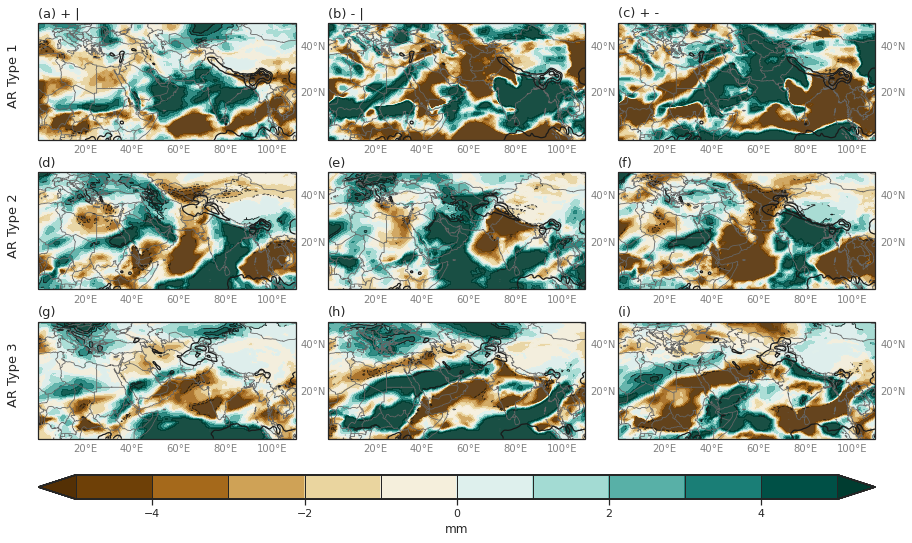

-16.055594435730278 13.378327261662363
-12.294800632444879 12.312632571454998
-13.595486188310849 13.931886760722154
-12.169753047420922 13.527223253728799
-8.272807538430834 8.044252348352316
-11.541234936158661 10.16015485354213
-10.582745380320262 11.74053883797255
-10.02219261431016 12.361007759849983
-11.210700702540413 9.599160736132605


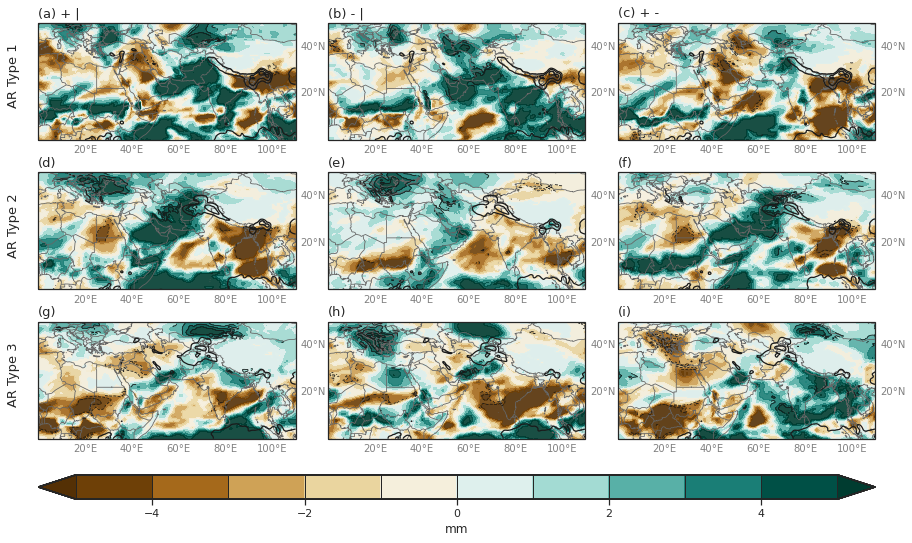

-17.13541222834047 15.974830895465963
-12.856786580984174 11.582080793554436
-10.963726765466973 10.624555241119019
-10.2260460729572 11.523170654084893
-9.771055264733754 7.177704326918839
-10.16808809075668 7.885519097552528
-11.556052973438852 11.929947242455636
-10.82988340962278 9.448047345537464
-6.1593461702224435 7.786355644054651


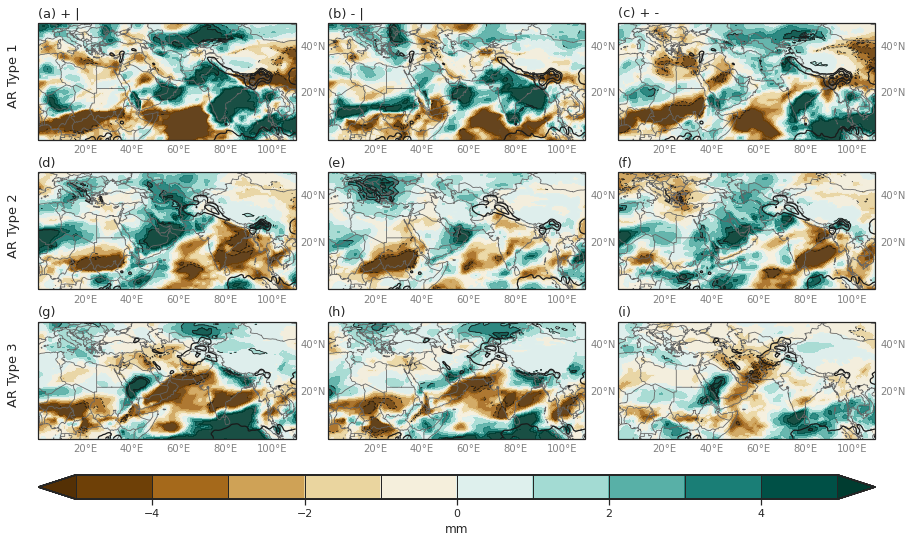

In [42]:
plot_ds = [enso_diff, ao_diff, sh_diff]
pval_ds = [enso_pval, ao_pval, sh_pval]
names = ['ENSO', 'AO', 'SH']
artype_lst = [1]*3 + [2]*3 + [3]*3
for i, cliindex in enumerate(names):
    diff_data = plot_ds[i]
    pval_data = pval_ds[i]
    filepath = fig_path + 'composite_diff_iwv_' + cliindex + '.png'
    nrows = nk
    ncols = 3
    sig_level = 0.05

    row_lbl = ['AR Type 1'] + ['']*2 + ['AR Type 2'] + ['']*2 + ['AR Type 3'] + ['']*2
    col_lbl = ['(a) + |', '(b) - |', '(c) + -',
               '(d)', '(e)','(f)',
               '(g)', '(h)', '(i)']

    # Create figure
    fig = plt.figure(figsize=(15, 10))

    # Set up Axes Grid
    axes_class = (GeoAxes,dict(map_projection=mapcrs))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                    cbar_location='bottom', cbar_mode='single',
                    cbar_pad=0.05, cbar_size='7%',label_mode='',
                    direction='row')
    for k, (ax, ar_type) in enumerate(zip(axgr, artype_lst)):
        data = diff_data[k]
        pval = pval_data[k]
        plot_dict = plot_dict_ivt
        # lat/lon arrays
        lats = data.lat.values
        lons = data.lon.values    
        ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy, left_lats=False, right_lats=True)

        iwv = data.tcwv.values
        iwv_mask = data.tcwv.where((pval.tcwv <= sig_level)).values

       # Contour Filled (all)
        print(iwv.min(), iwv.max())
        cflevs = np.arange(-5, 6, 1)
        cf = ax.contourf(lons, lats, iwv, transform=datacrs,
                         levels=cflevs, cmap='BrBG', alpha=0.9, extend='both') 

        # Contour Lines (250-hPa Heights ALL)
        clevs = cflevs
        cs = ax.contour(lons, lats, iwv_mask, transform=datacrs,
                        levels=clevs, colors='k', linewidths=0.8)
        
        # Contour Lines (Precip conditions)
        prec = precipitation.prec.sel(ar=ar_type)
        clevs = np.array([5, 10, 20])
        prec_sm = gaussian_filter(prec.values, sigma=2.0)
        cs = ax.contour(prec.lon, prec.lat, prec_sm, transform=datacrs,
                        levels=clevs, colors='k', linewidths=1.25)


        # subtitles
        ax.set_title(col_lbl[k], loc='left',fontsize=13)
        # Row labels
        ax.text(-0.07, 0.55, row_lbl[k], va='bottom', ha='center',
            rotation='vertical', rotation_mode='anchor', fontsize=13,
            transform=ax.transAxes)

    # Colorbar (single)
        cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
        cb.set_label('mm')

    # Save figure
    plt.savefig(filepath, dpi=300, bbox_inches='tight')

    # Show
    plt.show()


### Composite MJO

-4.92756155864097 5.304167640507238
-4.411642692358353 4.267983162432751
-4.62116386123747 4.142334808648299


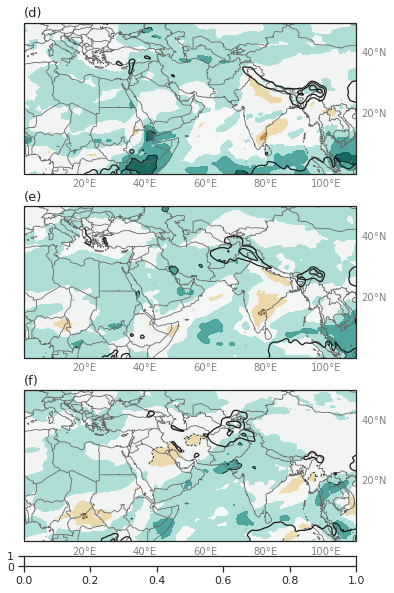

In [26]:
diff_data = plot_ds[i]
pval_data = pval_ds[i]
filepath = fig_path + 'composite_diff_mjo.png'
nrows = nk
ncols = 1
sig_level = 0.05
artype_lst = [1, 2, 3]
row_lbl = ['AR Type 1', 'AR Type 2', 'AR Type 3']
col_lbl1 = ['(a)', '(b)', '(c)']
col_lbl2 = ['(d)', '(e)', '(f)']


# Create figure
fig = plt.figure(figsize=(15, 10))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                cbar_location='bottom', cbar_mode='edge',
                cbar_pad=0.20, cbar_size='7%',label_mode='',
                direction='column')

################################
########## IVT PLOTS ###########
################################
for k, (ax, ar_type) in enumerate(zip(axgr, artype_lst)):
    data = mjo_diff[k]
    pval = mjo_pval[k]
    plot_dict = plot_dict_ivt
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy, left_lats=False, right_lats=True)

    iwv = data.tcwv.values
    iwv_mask = data.tcwv.where((pval.tcwv <= sig_level)).values

   # Contour Filled (all)
    print(iwv.min(), iwv.max())
    cflevs = np.arange(-5, 6, 1)
    cf = ax.contourf(lons, lats, iwv, transform=datacrs,
                     levels=cflevs, cmap='BrBG', alpha=0.9, extend='both') 

    # Contour Lines (250-hPa Heights ALL)
    clevs = cflevs
    cs = ax.contour(lons, lats, iwv_mask, transform=datacrs,
                    levels=clevs, colors='k', linewidths=0.8)
     
    # Contour Lines (Precip conditions)
    prec = precipitation.prec.sel(ar=ar_type)
    clevs = np.array([5, 10, 20])
    prec_sm = gaussian_filter(prec.values, sigma=2.0)
    cs = ax.contour(prec.lon, prec.lat, prec_sm, transform=datacrs,
                    levels=clevs, colors='k', linewidths=1.25)
    # subtitles
    ax.set_title(col_lbl2[k], loc='left',fontsize=13)


# Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[1], orientation='horizontal', drawedges=True)
    cb.set_label('mm')
    
# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()
